In [22]:
%%javascript
// Run for table of contents.
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Tests of WMD in Gensim


<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

Note: run JavaScript cell in beginning to get table of contents.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

/home/olavur/.virtualenvs/RaRe_WMD/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import numpy as np
import json
from time import time
from copy import deepcopy
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec
from gensim.similarities.docsim import WmdSimilarity
from gensim.corpora import Dictionary
import random
from pyemd import emd
import line_profiler

/home/olavur/.virtualenvs/RaRe_WMD/local/lib/python2.7/site-packages/pkg_resources/__init__.py:1222: UserWarning: /home/olavur/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [8]:
# Load some text data.
# Yelp review data from https://www.yelp.com/dataset_challenge/dataset.
n_lines = 1000
stop_words = stopwords.words(fileids='english')
documents = []
with open('../../../yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json') as data_file:
    for i, line in enumerate(data_file):
        if i == n_lines:
            break
        json_line = json.loads(line)
        text = json_line['text'].lower()  # Lower the text.
        text = word_tokenize(text)  # Split into words.
        text = [w for w in text if not w in stop_words]  # Remove stopwords.
        text = [w for w in text if w.isalpha()]  # Remove numbers and punctuation.
        documents.append(text)

In [15]:
# Train word2vec model.
model = Word2Vec(documents, workers=3)
model.init_sims(replace=True)  # Important: `init_sims()` BEFORE `init_distances()`.
#model.init_distances()

## `wmdistance` tests

### Plotting WMD, RWMD and WCD

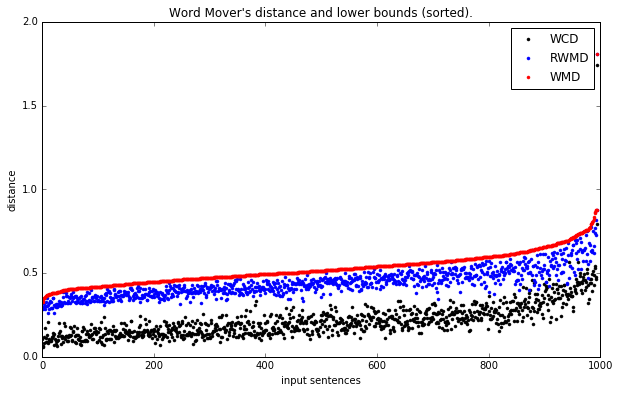

In [10]:
wmd = []
wcd = []
rwmd = []
n_dist = 1000
# Compute n_dist distances.
for i in range(n_dist):
    len1 = np.random.randint(4, 60)
    len2 = np.random.randint(4, 60)
    # Random words from vocab.
    #sent1 = [random.choice(model.vocab.keys()) for i in range(len1)]
    #sent2 = [random.choice(model.vocab.keys()) for i in range(len2)]
    # or
    # Random documents from corpus.
    sent1 = random.choice(documents)
    sent2 = random.choice(documents)
    wcd.append(model.wmdistance(sent1, sent2, WCD=True))
    rwmd.append(model.wmdistance(sent1, sent2, RWMD=True))
    wmd.append(model.wmdistance(sent1, sent2))
    
# Sort WMD, and sort others accordingly.
wmd = np.array(wmd)
wcd = np.array(wcd)
rwmd = np.array(rwmd)
idx = np.argsort(wmd)
wmd = wmd[idx]
wcd = wcd[idx]
rwmd = rwmd[idx]

plt.figure(figsize=(10, 6))
plt.hold(True)
plt.plot(wcd, 'k.')
plt.plot(rwmd, 'b.')
plt.plot(wmd, 'r.')
plt.hold(False)
plt.legend(['WCD', 'RWMD', 'WMD'], numpoints=1)
plt.ylabel('distance')
plt.xlabel('input sentences')
plt.title('Word Mover\'s distance and lower bounds (sorted).')
plt.show()

In [11]:
# Checking that RWMD < WMD, as it is supposed to.
# Seems to only fail when 
#     * the distance is "inf" (empty documents), or
#     * the distance is 0 (identical documents).
print len(wmd)
print sum(rwmd < wmd)  # rwmd < wmd
print wmd[rwmd == wmd]  # rwmd and wmd equal.
print wmd[rwmd > wmd] - rwmd[rwmd > wmd]  # Difference between rwmd and wmd where rwmd > wmd.
print wmd[wmd < np.inf].max()  # Maximal wmd value that is not inf.
print wmd[wmd > 0].min()  # Minimal wmd value that is not 0.

1000
986
[ inf  inf  inf  inf]
[ -5.39985600e-07  -1.88169878e-06  -1.96176733e-06  -1.66087423e-05
  -7.71093365e-08  -1.87649727e-08  -6.42785723e-06  -5.15355605e-06
  -1.14346547e-08  -2.16227031e-05]
1.80595618843
0.32890876407


### Compute time, WMD, WCD, RWMD

In [20]:
twmd = []
twcd = []
trwmd = []
n_dist = 1000
# Compute n_dist distances.
for i in range(n_dist):
    # Lengths of documents.
    len1 = np.random.randint(4, 60)
    len2 = np.random.randint(4, 60)
    # Random documents.
    sent1 = [random.choice(model.vocab.keys()) for i in range(len1)]
    sent2 = [random.choice(model.vocab.keys()) for i in range(len2)]
    
    # Time the computations.
    start = time()
    temp = model.wmdistance(sent1, sent2, WCD=True)
    twcd.append(time() - start)
    
    start = time()
    temp = model.wmdistance(sent1, sent2, RWMD=True)
    trwmd.append(time() - start)
    
    start = time()
    temp = model.wmdistance(sent1, sent2)
    twmd.append(time() - start)
    
# Sort WMD, and sort others accordingly.
twmd = np.array(twmd)
twcd = np.array(twcd)
trwmd = np.array(trwmd)
idx = np.argsort(twmd)
twmd = twmd[idx]
twcd = twcd[idx]
trwmd = trwmd[idx]

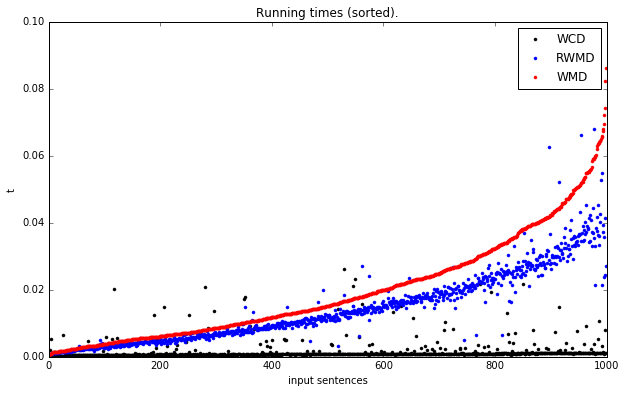

In [17]:
plt.figure(figsize=(10, 6))
plt.hold(True)
plt.plot(twcd, 'k.')
plt.plot(trwmd, 'b.')
plt.plot(twmd, 'r.')
plt.hold(False)
plt.legend(['WCD', 'RWMD', 'WMD'], numpoints=1)
plt.ylabel('t')
plt.xlabel('input sentences')
plt.title('Running times (sorted).')
plt.show()

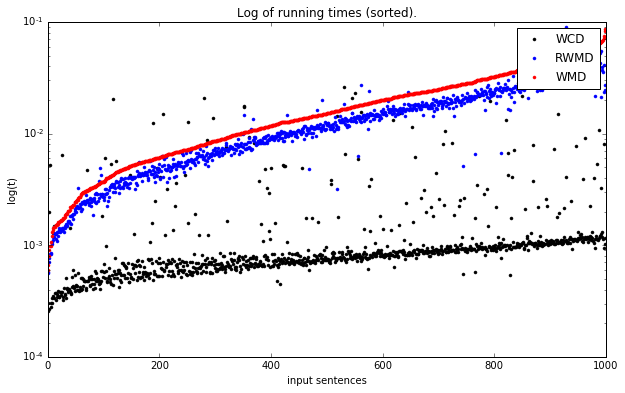

In [18]:
plt.figure(figsize=(10, 6))
plt.hold(True)
plt.semilogy(twcd, 'k.')
plt.semilogy(trwmd, 'b.')
plt.semilogy(twmd, 'r.')
plt.hold(False)
plt.legend(['WCD', 'RWMD', 'WMD'], numpoints=1)
plt.ylabel('log(t)')
plt.xlabel('input sentences')
plt.title('Log of running times (sorted).')
plt.show()

#### Running times, pre-computed distances



In [19]:
model.init_distances()

# Run cell to time WMD, RWMD, WCD.

# NOTE: RWMD and WCD are not ALWAYS faster than WMD.

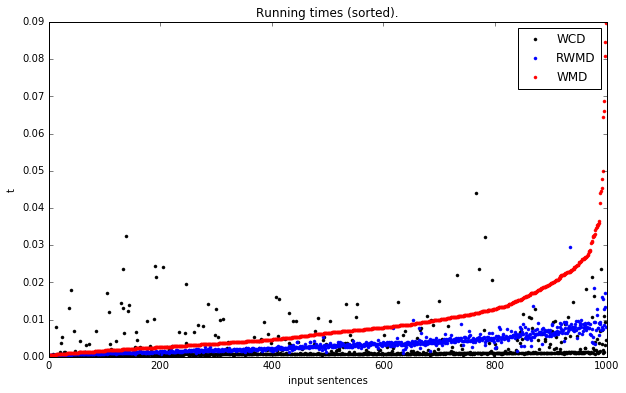

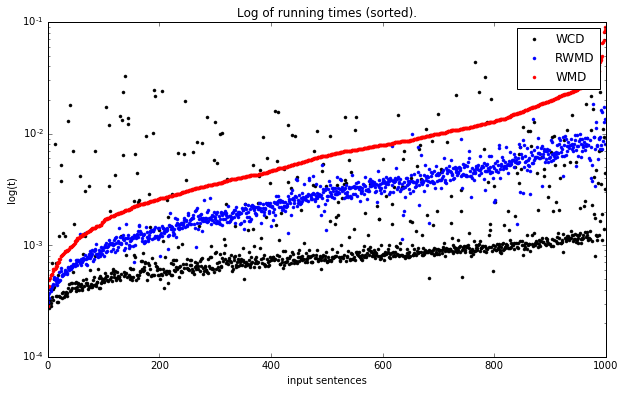

In [21]:
plt.figure(figsize=(10, 6))
plt.hold(True)
plt.plot(twcd, 'k.')
plt.plot(trwmd, 'b.')
plt.plot(twmd, 'r.')
plt.hold(False)
plt.legend(['WCD', 'RWMD', 'WMD'], numpoints=1)
plt.ylabel('t')
plt.xlabel('input sentences')
plt.title('Running times (sorted).')
plt.show()

plt.figure(figsize=(10, 6))
plt.hold(True)
plt.semilogy(twcd, 'k.')
plt.semilogy(trwmd, 'b.')
plt.semilogy(twmd, 'r.')
plt.hold(False)
plt.legend(['WCD', 'RWMD', 'WMD'], numpoints=1)
plt.ylabel('log(t)')
plt.xlabel('input sentences')
plt.title('Log of running times (sorted).')
plt.show()

## `WmdSimilarity` tests

### Testing prefetch and prune correctness

In [20]:
# Prefetch and prune should give same result as full WMD computation (top results).

num_best = 10

corpus = documents[:100]

index1 = WmdSimilarity(corpus, model, num_best=num_best, pp=False)
index2 = WmdSimilarity(corpus, model, num_best=num_best, pp=True)
for i in range(100):
    query = [random.choice(model.vocab.keys()) for i in range(4)]

    sims1 = index1[query]

    sims2 = index2[query]

    # If, for any query, the output of the prefetch and prune algorithm is 
    # different from the brute force algorith, there is some mistake.
    for i in range(len(sims1)):
        if not np.isclose(sims1[i][1], sims2[i][1]):
            assert False, 'Mistake!'

### Speed-up from prefetch and prune

In [6]:
# Test speed-up from prefetch and prune.

num_best = 10

corpus = documents[:100]

t1 = []
tpp = []

index1 = WmdSimilarity(corpus, model, num_best=num_best, pp=False)
indexpp = WmdSimilarity(corpus, model, num_best=num_best, pp=True)

for i in range(10):
    query = [random.choice(model.vocab.keys()) for i in range(10, 100)]

    # Time with and without prefetch and prune.
    
    start = time()
    sims = index1[query]
    t1.append(time() - start)

    start = time()
    sims = indexpp[query]
    tpp.append(time() - start)
    
# Sort full WMD time, and sort others accordingly.
t1 = np.array(t1)
tpp = np.array(tpp)
idx = np.argsort(t1)
t1 = t1[idx]
tpp = tpp[idx]

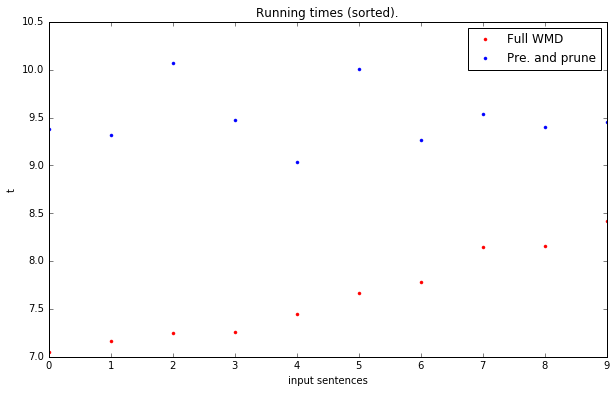

In [7]:
plt.figure(figsize=(10, 6))
plt.hold(True)
plt.plot(t1, 'r.')
plt.plot(tpp, 'b.')
plt.hold(False)
plt.legend(['Full WMD', 'Pre. and prune'], numpoints=1)
plt.ylabel('t')
plt.xlabel('input sentences')
plt.title('Running times (sorted).')
plt.show()

#### Speed-up of prefetch and prune with precomputed distances

In [8]:
# Test speed-up from prefetch and prune.

num_best = 10

corpus = documents[:100]

t1 = []
tpp = []

index1 = WmdSimilarity(corpus, model, num_best=num_best, pp=False, init_distances=True)
indexpp = WmdSimilarity(corpus, model, num_best=num_best, pp=True, init_distances=True)

for i in range(10):
    query = [random.choice(model.vocab.keys()) for i in range(10, 100)]

    # Time with and without prefetch and prune.
    
    start = time()
    sims = index1[query]
    t1.append(time() - start)

    start = time()
    sims = indexpp[query]
    tpp.append(time() - start)
    
# Sort full WMD time, and sort others accordingly.
t1 = np.array(t1)
tpp = np.array(tpp)
idx = np.argsort(t1)
t1 = t1[idx]
tpp = tpp[idx]

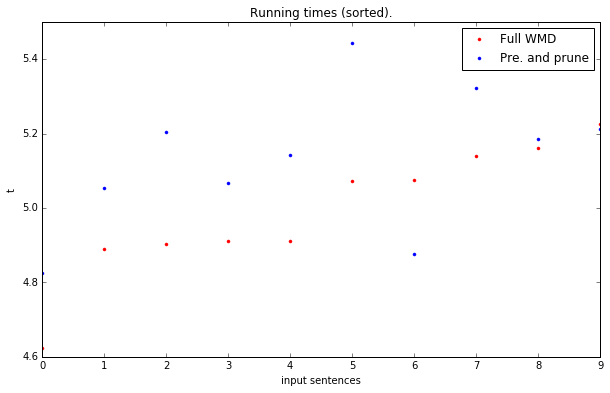

In [9]:
plt.figure(figsize=(10, 6))
plt.hold(True)
plt.plot(t1, 'r.')
plt.plot(tpp, 'b.')
plt.hold(False)
plt.legend(['Full WMD', 'Pre. and prune'], numpoints=1)
plt.ylabel('t')
plt.xlabel('input sentences')
plt.title('Running times (sorted).')
plt.show()

## Profiling

In [10]:
# Some sentences to test.
sent1 = [u'center', u'joe', u'brewed', u'oily', u'torte', u'art', u'cut', u'frame', u'nothing', u'medium', u'thrift', u'specific', u'starbucks', u'skills', u'wo', u'name', u'let', u'lacking', u'happen', u'option', u'word', u'bathroom', u'wish', u'positive', u'cheeseburger', u'door', u'today', u'side', u'smell', u'absolute', u'dumplings', u'enter', u'combination', u'ignored', u'jim', u'haluski', u'top', u'tso', u'update', u'dad', u'bus', u'eagle', u'chow', u'barnes', u'paying', u'cab', u'delish', u'handle']
sent2 = [u'receive', u'saturday', u'number', u'spicy', u'cleaned', u'delightful', u'diet', u'run', u'seem', u'dinner', u'survey', u'bath', u'wedge', u'reuben', u'lots', u'funny', u'give', u'crowded', u'joe', u'apologized', u'due', u'permit', u'build', u'included', u'egg', u'bright', u'pro', u'made', u'tell', u'china', u'noise', u'amount', u'mashed', u'people', u'standing', u'broccoli', u'dry', u'undercooked', u'ton', u'cool', u'plus', u'deserts', u'view', u'broth', u'pool', u'hole', u'needed', u'girl', u'yes', u'bite', u'run', u'mckees', u'decent', u'lovely', u'patty', u'swear']

In [31]:
# Or randomized sentences.
sentlen = 100
sent1 = [random.choice(model.vocab.keys()) for i in range(sentlen)]
sent2 = [random.choice(model.vocab.keys()) for i in range(sentlen)]

## Profiling WMD

In [11]:
profile = line_profiler.LineProfiler(model.wmdistance)
result = profile.runcall(model.wmdistance, sent1, sent2)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 0.058417 s
File: /home/olavur/RaRe/WMD/gensim/gensim/models/word2vec.py
Function: wmdistance at line 1200

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1200                                               def wmdistance(self, document1, document2, WCD=False, RWMD=False, force_pure_python=False):
  1201                                                   """
  1202                                                   Compute the Word Mover's Distance between two documents. When using this
  1203                                                   code, please consider citing the following papers:
  1204                                                   * Ofir Pele and Michael Werman, "A linear time histogram metric for improved SIFT matching".
  1205                                                   * Ofir Pele and Michael Werman, "Fast and robust earth mover's distances".
  1206                                                   * Matt Kusner 

## Profiling WCD

In [12]:
profile = line_profiler.LineProfiler(model.wmdistance)
result = profile.runcall(model.wmdistance, sent1, sent2, WCD=True)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 0.014059 s
File: /home/olavur/RaRe/WMD/gensim/gensim/models/word2vec.py
Function: wmdistance at line 1200

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1200                                               def wmdistance(self, document1, document2, WCD=False, RWMD=False, force_pure_python=False):
  1201                                                   """
  1202                                                   Compute the Word Mover's Distance between two documents. When using this
  1203                                                   code, please consider citing the following papers:
  1204                                                   * Ofir Pele and Michael Werman, "A linear time histogram metric for improved SIFT matching".
  1205                                                   * Ofir Pele and Michael Werman, "Fast and robust earth mover's distances".
  1206                                                   * Matt Kusner 

## Profiling RWMD

In [13]:
profile = line_profiler.LineProfiler(model.wmdistance)
result = profile.runcall(model.wmdistance, sent1, sent2, RWMD=True)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 0.077634 s
File: /home/olavur/RaRe/WMD/gensim/gensim/models/word2vec.py
Function: wmdistance at line 1200

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1200                                               def wmdistance(self, document1, document2, WCD=False, RWMD=False, force_pure_python=False):
  1201                                                   """
  1202                                                   Compute the Word Mover's Distance between two documents. When using this
  1203                                                   code, please consider citing the following papers:
  1204                                                   * Ofir Pele and Michael Werman, "A linear time histogram metric for improved SIFT matching".
  1205                                                   * Ofir Pele and Michael Werman, "Fast and robust earth mover's distances".
  1206                                                   * Matt Kusner 

## Profiling `init_distances()`

In [14]:
profile = line_profiler.LineProfiler(model.init_distances)
result = profile.runcall(model.init_distances)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 24.0446 s
File: /home/olavur/RaRe/WMD/gensim/gensim/models/word2vec.py
Function: init_distances at line 1331

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1331                                               def init_distances(self):
  1332                                                   '''
  1333                                                   Compute the euclidean distance between all the words in the provided
  1334                                                   vocabulary, and store in a matrix. This matrix is used in `wmdistance`,
  1335                                                   if provided.
  1336                                           
  1337                                                   Input:
  1338                                                   vocab:      List of word tokens to compute distances between. Make sure
  1339                                                               it doesn't contai

## Profiling WmdSimilarity

In [15]:
num_best = 10

corpus = documents

query = [u'center', u'joe', u'brewed', u'oily', u'torte', u'art', u'cut', u'frame', u'nothing', u'medium', u'thrift', u'specific', u'starbucks', u'skills', u'wo', u'name', u'let', u'lacking', u'happen', u'option', u'word', u'bathroom', u'wish', u'positive', u'cheeseburger', u'door', u'today', u'side', u'smell', u'absolute', u'dumplings', u'enter', u'combination', u'ignored', u'jim', u'haluski', u'top', u'tso', u'update', u'dad', u'bus', u'eagle', u'chow', u'barnes', u'paying', u'cab', u'delish', u'handle']

index1 = WmdSimilarity(corpus, model, num_best=num_best, pp=False, normalize_w2v=False)
index2 = WmdSimilarity(corpus, model, num_best=num_best, pp=True, normalize_w2v=False)

### Without pre. and prune.

In [16]:
profile = line_profiler.LineProfiler(index1.get_similarities)
result = profile.runcall(index1.get_similarities, query)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 27.4762 s
File: /home/olavur/RaRe/WMD/gensim/gensim/similarities/docsim.py
Function: get_similarities at line 634

Line #      Hits         Time  Per Hit   % Time  Line Contents
   634                                               def get_similarities(self, query):
   635                                                   """
   636                                                   **Do not use this function directly; use the self[query] syntax instead.**
   637                                                   """
   638         1            5      5.0      0.0          if isinstance(query, numpy.ndarray):
   639                                                       # Convert document indeces to actual documents.
   640                                                       query = [self.corpus[i] for i in query]
   641                                           
   642         1            3      3.0      0.0          if not isinstance(query[0], list):
 

### With pre. and prune

In [17]:
profile = line_profiler.LineProfiler(index2.get_similarities)
result = profile.runcall(index2.get_similarities, query)
profile.print_stats()

Timer unit: 1e-06 s

Total time: 39.1695 s
File: /home/olavur/RaRe/WMD/gensim/gensim/similarities/docsim.py
Function: get_similarities at line 634

Line #      Hits         Time  Per Hit   % Time  Line Contents
   634                                               def get_similarities(self, query):
   635                                                   """
   636                                                   **Do not use this function directly; use the self[query] syntax instead.**
   637                                                   """
   638         1            8      8.0      0.0          if isinstance(query, numpy.ndarray):
   639                                                       # Convert document indeces to actual documents.
   640                                                       query = [self.corpus[i] for i in query]
   641                                           
   642         1            5      5.0      0.0          if not isinstance(query[0], list):
 